### 생선 분류 ==> 최적의 k 찾기 : 하이퍼파라미터
- 데이터셋: fish.csv
- 피쳐/특성 : Weight, Length
- 타켓/라벨 : Species
- 학습방법 : 지도학습 => 분류
- 학습알고리즘 : 최근접이웃알고리즘
- 하이퍼파라미터 튜닝 : 모델 성능 개선

[1] 데이터 준비

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

In [96]:
DATA_FILE='../data/fish.csv'

In [97]:
# 행 : Bream, Smelt 
# 컬럼 : Species, Weight, Height => 0,1,2
fishDF=pd.read_csv(DATA_FILE,usecols=['Species','Weight','Length'])

In [98]:
mask=(fishDF['Species']=='Bream')|(fishDF['Species']=='Smelt')
twoDF=fishDF[mask]
twoDF.reset_index(drop=True,inplace=True)
twoDF.index

RangeIndex(start=0, stop=49, step=1)

In [99]:
## Species 컬럼을 수치화 => Bream 0 , Smelt 1
twoDF['Code']=twoDF['Species'].replace({'Bream':0,'Smelt':1})

C:\Users\KDP-30\AppData\Local\Temp\ipykernel_4824\1035029973.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twoDF['Code']=twoDF['Species'].replace({'Bream':0,'Smelt':1})


In [100]:
twoDF.head()

,Species,Weight,Length,Code
0,Bream,242.0,25.4,0
1,Bream,290.0,26.3,0
2,Bream,340.0,26.5,0
3,Bream,363.0,29.0,0
4,Bream,430.0,29.0,0


[2] 피쳐와 타겟 분리

In [101]:
features=twoDF[['Weight','Length']]
target=twoDF['Code']

print(f'features => {features.shape}, {features.ndim}D')
print(f'target => {target.shape}, {target.ndim}D')

features => (49, 2), 2D
target => (49,), 1D


[3] 데이터셋 준비 => 학습용, 테스트용

In [102]:
from sklearn.model_selection import train_test_split

In [103]:
# train:test = 80:20 ==> test_size=0.2 또는 train_size=0.8
# defalut : 0.75:0.25
# stratify 매개변수 : 분류일 경우 사용, 분류 타겟의 종류에 대한 비율을 고려
X_train,X_test,Y_train,Y_test=train_test_split(features,target,
                                               test_size=0.2,
                                               stratify=target,
                                               random_state=10)

In [104]:
print(f'X_train => {X_train.shape}, {X_train.ndim}D')
print(f'X_test => {X_test.shape}, {X_test.ndim}D')

print(f'Y_train => {Y_train.shape}, {Y_train.ndim}D')
print(f'Y_test => {Y_test.shape}, {Y_test.ndim}D')

X_train => (39, 2), 2D
X_test => (10, 2), 2D
Y_train => (39,), 1D
Y_test => (10,), 1D


In [105]:
# target 0(Bream), 1(Smelt)의 비율
Y_train.value_counts()[0]/Y_train.shape[0],Y_train.value_counts()[1]/Y_train.shape[0]

(0.717948717948718, 0.28205128205128205)

In [106]:
Y_test.value_counts()[0]/Y_test.shape[0],Y_test.value_counts()[1]/Y_test.shape[0]

(0.7, 0.3)

[3-2] 피쳐 스케일링

In [107]:
from sklearn.preprocessing import MinMaxScaler

In [108]:
# 스케일러 인스턴스 생성
mnScaler=MinMaxScaler()

In [109]:
# 데이터에 기반한 MinMaxScaling 동작을 위한 학습 진행
mnScaler.fit(X_train)

MinMaxScaler()

In [110]:
mnScaler.min_,mnScaler.data_min_,mnScaler.scale_,mnScaler.data_max_

(array([-0.00674519, -0.31410256]),
 array([6.7, 9.8]),
 array([0.00100675, 0.03205128]),
 array([1000.,   41.]))

In [111]:
# 학습용 데이터셋 스케일링
X_train_scaled=mnScaler.transform(X_train)
X_train_scaled.shape,X_train_scaled.min(),X_train_scaled.max()

((39, 2), 0.0, 1.0000000000000002)

In [112]:
# 테스트 데이터셋 스케일링
X_test_scaled=mnScaler.transform(X_test)
X_test_scaled.shape,X_test_scaled.min(),X_test_scaled.max()

((10, 2), 0.0033222591362126247, 0.8489882210812445)

[4] 훈련/학습 진행
- 학습 알고리즘 인스턴스 생성
- 학습진행 => fit()

In [113]:
from sklearn.neighbors import KNeighborsClassifier

In [114]:
# 인스턴스 생성
model=KNeighborsClassifier()

In [115]:
# 학습 진행 => 학습용 데이터셋
model.fit(X_train_scaled,Y_train)

KNeighborsClassifier()

In [116]:
# 학습후 모델 파라미터 확인
model.classes_,model.n_samples_fit_

(array([0, 1], dtype=int64), 39)

[5] 모델 성능평가 ==> score() 메서드 + 테스트 데이터셋

In [117]:
model.score(X_test_scaled,Y_test)

1.0

[6] 최적의 k 개수 찾기 ==> 모델의 성능 영향 미치는 파라미터
- 하이퍼파라미터

In [118]:
# k의 범위 : 1~ 전체 데이터 개수
scores=[]
points=[]
for k in range(1,40):
    # 최근접 이웃 데이터 수 설정
    model.n_neighbors=k

    # 모델 예측 값 추출
    model.fit(X_train_scaled,Y_train)

    # 점수 계산alc wjwkd
    jumsu=model.score(X_test_scaled,Y_test)

    if k>1:
        if jumsu != scores[-1]:
            points.append(k)
            
    scores.append(jumsu)

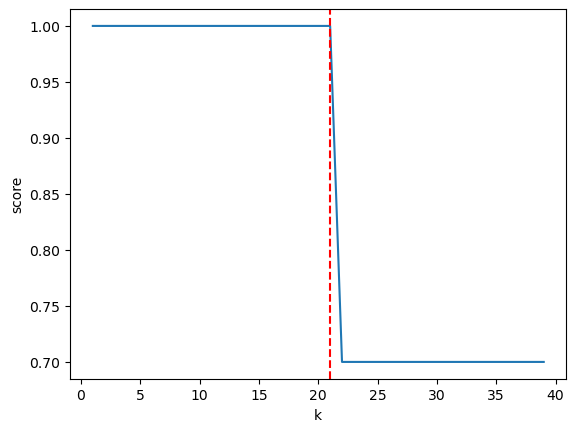

In [119]:
import numpy as np

# x축 k, y축 점수
plt.plot(range(1,40),scores)
plt.xlabel('k')
plt.ylabel('score')
plt.axvline(np.array(points)-1,0.0,1.0,color='red',linestyle='dashed')
plt.show()

[7] 예측하기 ==> 학습/훈련과 테스트에 사용되지 않은 데이터 사용
- 주의 : 입력데이터 ==> 2D

In [120]:
new_data=pd.DataFrame([[413,27.8]],columns=['Weight','Length'])
new_data

,Weight,Length
0,413,27.8


In [121]:
new_data_scaled=mnScaler.transform(new_data)

In [122]:
# 임의의 새로운 데이터의 예측
model.predict(new_data_scaled)

array([0], dtype=int64)

In [123]:
### 최 근접한 k개 데이터 찾기
### defalut: n_neighbors =5 
distance,index=model.kneighbors(new_data_scaled)

In [124]:
distance

array([[0.04209753, 0.06334927, 0.07138647, 0.07421737, 0.07974703,
        0.08448221, 0.10667685, 0.12006426, 0.13283514, 0.13487345,
        0.14742788, 0.15337025, 0.23143819, 0.25707598, 0.26964939,
        0.29923871, 0.3005092 , 0.33355916, 0.33834045, 0.35427164,
        0.36978152, 0.38571904, 0.57002596, 0.61493269, 0.62276118,
        0.63676715, 0.63743027, 0.64447977, 0.64901627, 0.65396783,
        0.66044108, 0.66734496, 0.66921546, 0.67438368, 0.68627917,
        0.68648846, 0.68855791, 0.70647952, 0.70721597]])

In [125]:
index

array([[25, 22, 21,  0,  6, 17, 29, 10,  2, 36, 12, 37, 33, 30, 23, 31,
        11,  9, 14, 24, 26, 16,  5, 35,  3, 20, 18,  4,  1, 27,  7, 28,
        15, 19, 13, 38, 32, 34,  8]], dtype=int64)

In [126]:
# 1차원으로 줄인뒤 리스트화
idx=index.reshape(-1).tolist()

In [127]:
X_train_scaled[idx]

array([[4.26155240e-01, 6.15384615e-01],
       [3.58703312e-01, 6.15384615e-01],
       [4.46290144e-01, 6.37820513e-01],
       [3.85885432e-01, 6.47435897e-01],
       [4.46290144e-01, 6.47435897e-01],
       [3.35548173e-01, 5.35256410e-01],
       [4.96627404e-01, 6.37820513e-01],
       [4.71458774e-01, 6.79487179e-01],
       [2.85210913e-01, 5.28846154e-01],
       [4.96627404e-01, 6.79487179e-01],
       [4.96627404e-01, 6.95512821e-01],
       [3.35548173e-01, 7.11538462e-01],
       [5.97301923e-01, 7.11538462e-01],
       [5.72133293e-01, 7.75641026e-01],
       [6.07369375e-01, 7.59615385e-01],
       [6.17436827e-01, 7.91666667e-01],
       [6.47639183e-01, 7.59615385e-01],
       [6.97976442e-01, 7.43589744e-01],
       [6.82875264e-01, 7.75641026e-01],
       [6.77841538e-01, 8.07692308e-01],
       [6.97976442e-01, 8.07692308e-01],
       [7.18111346e-01, 8.07692308e-01],
       [1.32890365e-02, 1.66666667e-01],
       [9.19460385e-01, 9.19871795e-01],
       [5.537098

In [128]:
k_weight=X_train_scaled[idx][:,0]
k_length=X_train_scaled[idx][:,1]

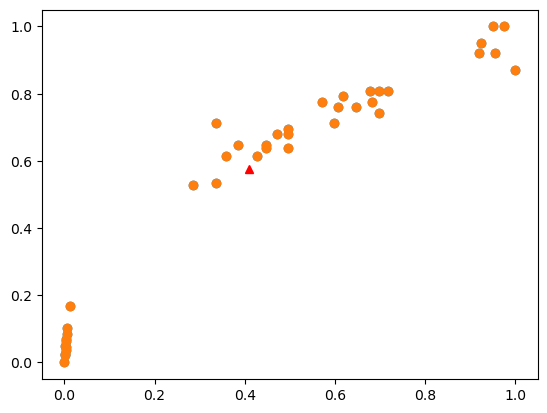

In [129]:
## 시각화로 확인
# 도미(Bream), 빙어(Smelt)에 대한 시각화
#plt.scatter(twoDF[twoDF['Species']=='Bream']['Weight'],twoDF[twoDF['Species']=='Bream']['Length'])
#plt.scatter(twoDF[twoDF['Species']=='Smelt']['Weight'],twoDF[twoDF['Species']=='Smelt']['Length'])
plt.scatter(X_train_scaled[:,0],X_train_scaled[:,1])
plt.plot(new_data_scaled[0,0],new_data_scaled[0,1],'r^')
plt.scatter(k_weight,k_length)
plt.show()